# BO3 – Team Segmentation by Playing Style

## 1. Business Understanding

**Business Objective:** Segment teams by playing style (aggressive, high press, defensive, clinical, set-pieces, balanced) to:

- Track tactical evolution of clubs over seasons
- Detect outliers (sudden tactical changes or atypical styles)
- Provide tactical insights for coaching and scouting decisions

**Analysis Level:** Team-season aggregated data (one record = one team's performance over an entire season)


**Approach:** This is an **unsupervised learning** problem. We use three clustering algorithms:
- **KMeans:** Partitioning-based, simple and interpretable
- **Gaussian Mixture Models (GMM):** Probabilistic, captures soft cluster boundaries and overlapping styles
- **DBSCAN:** Density-based, identifies outliers and atypical tactical approaches

**Dataset:** `team_season_aggregated.csv` - Season-level team statistics from Premier League historical data

## 2. Imports & Configuration

In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.neighbors import NearestNeighbors
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
sns.set_style('whitegrid')
sns.set_context('notebook')
plt.rcParams['figure.figsize'] = (12, 6)

RANDOM_STATE = 42
print(' All libraries imported successfully')

 All libraries imported successfully


## 3. Data Understanding

In [47]:
# Data loading - try multiple path variations
base_path = Path('.').resolve()
team_file = base_path.parent / 'data' / 'processed' / 'team_season_aggregated.csv'

if not team_file.exists():
    # Try alternative path
    team_file = base_path / 'data' / 'processed' / 'team_season_aggregated.csv'
    
if not team_file.exists():
    raise FileNotFoundError(f'File not found at: {team_file}')

print(f' Loading data from: {team_file}')
df = pd.read_csv(team_file)

print(f'\n{"="*80}')
print(f'DATASET OVERVIEW')
print(f'{"="*80}')
print(f'Dataset Shape: {df.shape[0]} rows × {df.shape[1]} columns')
print(f'Seasons covered: {df["Season"].min()} to {df["Season"].max()}')
print(f'Unique teams: {df["Team"].nunique()}')

print(f'\n📊 Dataset Summary:')
print(f'   • ~{df.shape[0]} team-seasons (one record = one team\'s performance over a full season)')
print(f'   • {df.shape[1]} variables capturing performance, goals, shots, discipline, etc.')
print(f'   • Analysis level: Season-aggregated team statistics\n')

df.head()

 Loading data from: C:\Users\ezera\OneDrive\Desktop\4Arctic\S1\Machine Learning Appliqué\pl-standings-prediction-project\data\processed\team_season_aggregated.csv

DATASET OVERVIEW
Dataset Shape: 500 rows × 35 columns
Seasons covered: 2000-01 to 2024-25
Unique teams: 46

📊 Dataset Summary:
   • ~500 team-seasons (one record = one team's performance over a full season)
   • 35 variables capturing performance, goals, shots, discipline, etc.
   • Analysis level: Season-aggregated team statistics



,Season,Season_encoded,Team,Matches_Played,Home_Matches,Away_Matches,Wins,Draws,Losses,Home_Wins,...,Yellow_Cards,Red_Cards,Fouls,Corners,Avg_Corners,Win_Rate,Home_Win_Rate,Away_Win_Rate,Final_Position,Team_encoded
0,2000-01,0,Man United,38,19,19,24,8,6,15,...,44.0,3.0,433.0,269.0,7.078947,0.631579,0.789474,0.473684,1,27
1,2000-01,0,Arsenal,38,19,19,20,10,8,15,...,48.0,3.0,495.0,295.0,7.763158,0.526316,0.789474,0.263158,2,0
2,2000-01,0,Liverpool,38,19,19,20,9,9,13,...,50.0,4.0,473.0,243.0,6.394737,0.526316,0.684211,0.368421,3,24
3,2000-01,0,Leeds,38,19,19,20,8,10,11,...,72.0,3.0,589.0,270.0,7.105263,0.526316,0.578947,0.473684,4,22
4,2000-01,0,Ipswich,38,19,19,20,6,12,11,...,31.0,2.0,414.0,206.0,5.421053,0.526316,0.578947,0.473684,5,21


In [48]:
# Data structure and types
print(' Data Structure:')
print(df.info())

print(f'\n{"="*80}')
print('MISSING VALUES ANALYSIS')
print(f'{"="*80}')
missing = df.isnull().sum()
missing = missing[missing > 0].sort_values(ascending=False)

if len(missing) > 0:
    print(f'\nColumns with missing values:')
    for col, count in missing.items():
        pct = 100 * count / len(df)
        print(f'   • {col}: {count} ({pct:.2f}%)')
else:
    print('\n No missing values detected')

print(f'\n{"="*80}')
print('KEY COLUMNS FOR PLAYING STYLE ANALYSIS')
print(f'{"="*80}')
print('''
Important Features:
   • Offensive metrics: Avg_Shots, Avg_Shots_On_Target, Shot_Accuracy, Avg_Goals_Scored
   • Defensive metrics: Avg_Goals_Conceded, Clean_Sheet_Rate
   • Set-pieces: Avg_Corners
   • Discipline/Intensity: Fouls, Yellow_Cards, Red_Cards
   • Performance: Win_Rate, Points
''')

 Data Structure:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 35 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Season                 500 non-null    object 
 1   Season_encoded         500 non-null    int64  
 2   Team                   500 non-null    object 
 3   Matches_Played         500 non-null    int64  
 4   Home_Matches           500 non-null    int64  
 5   Away_Matches           500 non-null    int64  
 6   Wins                   500 non-null    int64  
 7   Draws                  500 non-null    int64  
 8   Losses                 500 non-null    int64  
 9   Home_Wins              500 non-null    int64  
 10  Away_Wins              500 non-null    int64  
 11  Points                 500 non-null    int64  
 12  Points_Per_Game        500 non-null    float64
 13  Goals_Scored           500 non-null    int64  
 14  Goals_Conceded         500 non-null    in

## 4. Feature Engineering – Playing Style Features

We engineer features that capture different tactical dimensions:

**Style Indicators:**
- **Aggressive/High Press:** High fouls, cards, shots, corners → pressing intensity
- **Defensive:** Low goals conceded, high clean sheet rate → defensive solidity
- **Clinical:** High goals per shot → offensive efficiency
- **Set-Pieces Oriented:** High corners per shot → reliance on set-pieces
- **Balanced:** Average values across all dimensions
- **Outliers:** Extreme or unusual combinations (e.g., high aggression but low success)

We create normalized per-match features to ensure fair comparison across teams with different fixture counts.

In [49]:
# Create a feature-engineered copy
df_feat = df.copy()

print(f'{"="*80}')
print('FEATURE ENGINEERING')
print(f'{"="*80}\n')

# Discipline / Aggression features (per match normalization)
df_feat['Fouls_per_Match'] = df_feat['Fouls'] / df_feat['Matches_Played']
df_feat['Yellow_per_Match'] = df_feat['Yellow_Cards'] / df_feat['Matches_Played']
df_feat['Red_per_Match'] = df_feat['Red_Cards'] / df_feat['Matches_Played']

# Avoid division by zero
df_feat['Cards_per_Foul'] = (df_feat['Yellow_Cards'] + df_feat['Red_Cards']) / df_feat['Fouls'].replace(0, np.nan)

# Offensive efficiency
df_feat['Goals_per_Shot'] = df_feat['Avg_Goals_Scored'] / df_feat['Avg_Shots'].replace(0, np.nan)

# Set-piece intensity
df_feat['Corners_per_Shot'] = df_feat['Avg_Corners'] / df_feat['Avg_Shots'].replace(0, np.nan)

print(' Created derived features:')
print('   • Fouls_per_Match, Yellow_per_Match, Red_per_Match')
print('   • Cards_per_Foul (disciplinary severity)')
print('   • Goals_per_Shot (offensive efficiency)')
print('   • Corners_per_Shot (set-piece reliance)\n')

# Select final feature set for clustering
style_features = [
    'Avg_Goals_Scored',
    'Avg_Goals_Conceded',
    'Avg_Shots',
    'Avg_Shots_On_Target',
    'Shot_Accuracy',
    'Clean_Sheet_Rate',
    'Avg_Corners',
    'Fouls_per_Match',
    'Yellow_per_Match',
    'Red_per_Match',
    'Cards_per_Foul',
    'Goals_per_Shot',
    'Corners_per_Shot',
]

print(f'Selected {len(style_features)} features for clustering:')
for i, feat in enumerate(style_features, 1):
    print(f'   {i:2d}. {feat}')

# Check for missing values in engineered features
print(f'\n📊 Feature Matrix Shape: {df_feat[style_features].shape}')
print(f'Missing values: {df_feat[style_features].isnull().sum().sum()}')

FEATURE ENGINEERING

 Created derived features:
   • Fouls_per_Match, Yellow_per_Match, Red_per_Match
   • Cards_per_Foul (disciplinary severity)
   • Goals_per_Shot (offensive efficiency)
   • Corners_per_Shot (set-piece reliance)

Selected 13 features for clustering:
    1. Avg_Goals_Scored
    2. Avg_Goals_Conceded
    3. Avg_Shots
    4. Avg_Shots_On_Target
    5. Shot_Accuracy
    6. Clean_Sheet_Rate
    7. Avg_Corners
    8. Fouls_per_Match
    9. Yellow_per_Match
   10. Red_per_Match
   11. Cards_per_Foul
   12. Goals_per_Shot
   13. Corners_per_Shot

📊 Feature Matrix Shape: (500, 13)
Missing values: 0


## 5. Data Preprocessing & Scaling

In [50]:
# Prepare feature matrix
X = df_feat[style_features].copy()

# Impute missing values with median
X = X.fillna(X.median())
print(f' Missing values imputed with median\n')

# Standardize features (mean=0, std=1)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
print(f' Features standardized using StandardScaler\n')

# Verify standardization
X_scaled_df = pd.DataFrame(X_scaled, columns=style_features)
print('Standardized feature statistics:')
print(X_scaled_df.describe().round(2).loc[['mean', 'std']])

 Missing values imputed with median

 Features standardized using StandardScaler

Standardized feature statistics:
      Avg_Goals_Scored  Avg_Goals_Conceded  Avg_Shots  Avg_Shots_On_Target  \
mean              -0.0                -0.0        0.0                 -0.0   
std                1.0                 1.0        1.0                  1.0   

      Shot_Accuracy  Clean_Sheet_Rate  Avg_Corners  Fouls_per_Match  \
mean            0.0               0.0         -0.0              0.0   
std             1.0               1.0          1.0              1.0   

      Yellow_per_Match  Red_per_Match  Cards_per_Foul  Goals_per_Shot  \
mean              -0.0           -0.0             0.0            -0.0   
std                1.0            1.0             1.0             1.0   

      Corners_per_Shot  
mean              -0.0  
std                1.0  


## 6. Exploratory Data Analysis – Feature Relationships

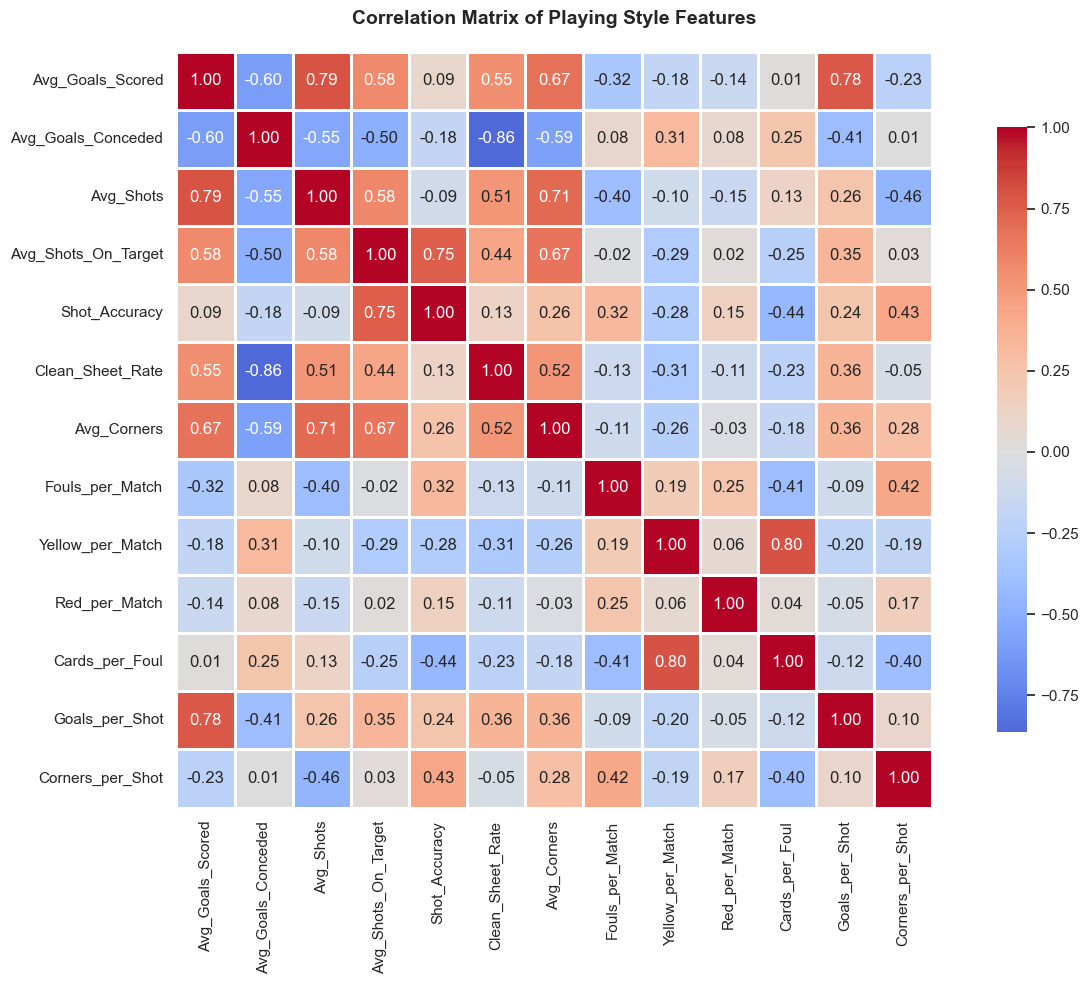

Key Correlations:
   • Offensive features (Goals, Shots, Shot Accuracy) likely correlate positively
   • Defensive features (Goals Conceded, Clean Sheets) likely negatively correlated
   • Discipline features (Fouls, Cards) may correlate with pressing intensity


In [29]:
# Correlation heatmap
plt.figure(figsize=(14, 10))
corr_matrix = df_feat[style_features].corr()
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0, 
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Correlation Matrix of Playing Style Features', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

print('Key Correlations:')
print('   • Offensive features (Goals, Shots, Shot Accuracy) likely correlate positively')
print('   • Defensive features (Goals Conceded, Clean Sheets) likely negatively correlated')
print('   • Discipline features (Fouls, Cards) may correlate with pressing intensity')

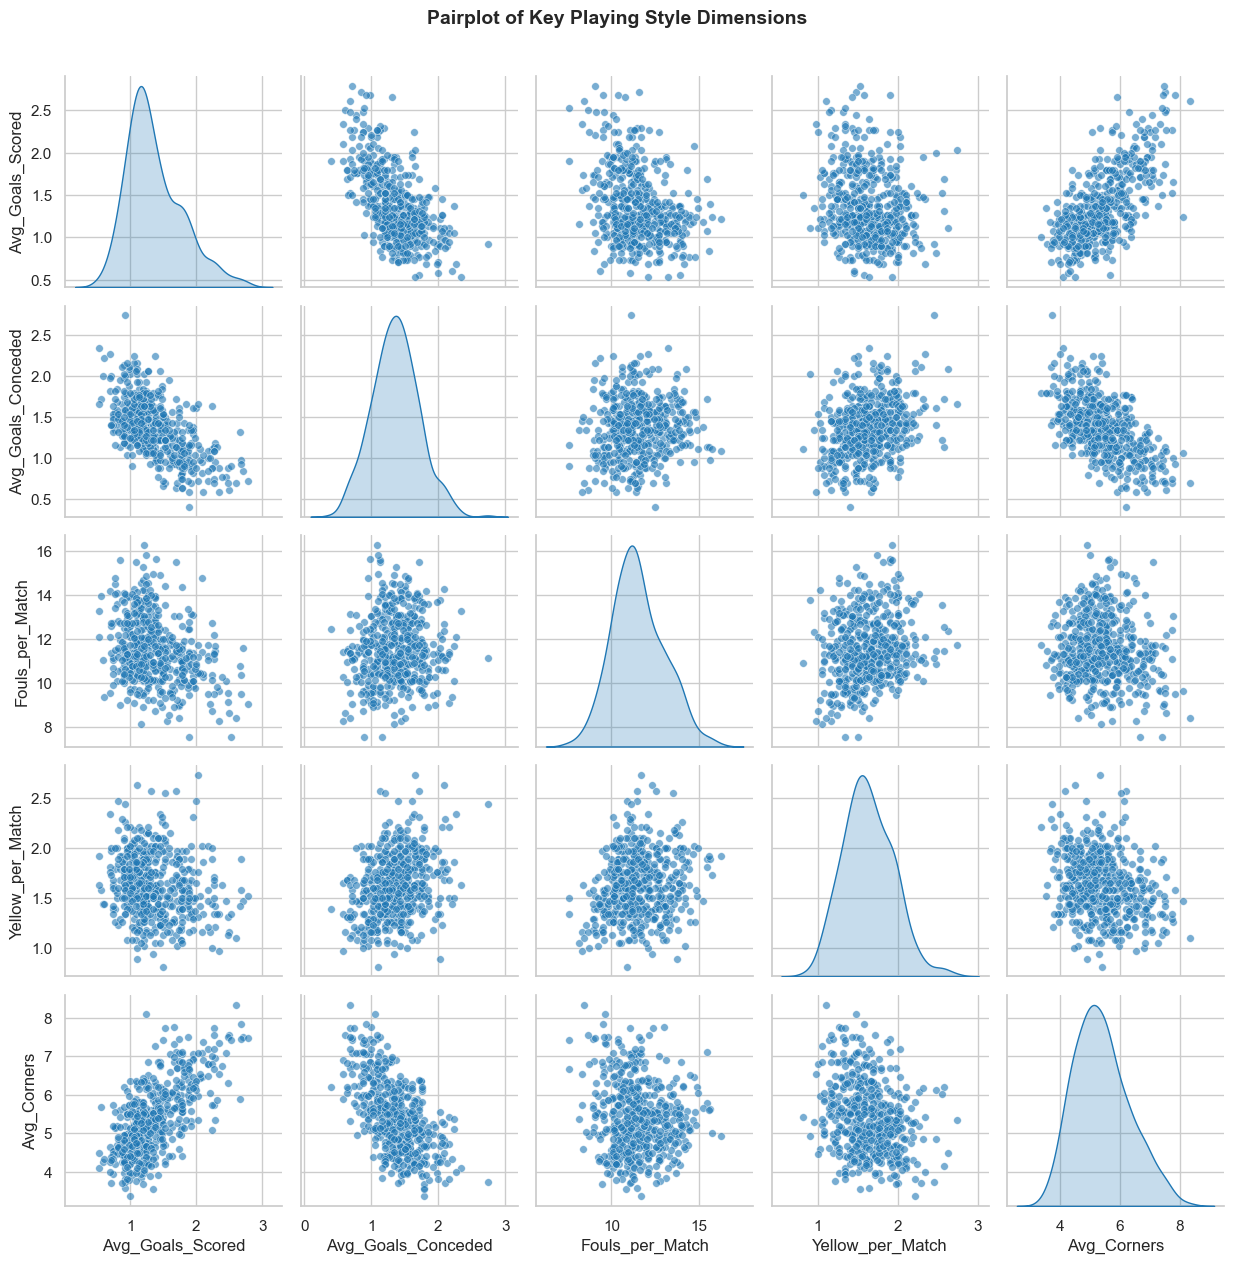

Pairplot Insights:
   • Visual inspection of feature distributions and relationships
   • Helps identify potential natural groupings in the data


In [30]:
# Pairplot for key tactical dimensions
key_features = ['Avg_Goals_Scored', 'Avg_Goals_Conceded', 'Fouls_per_Match', 
                'Yellow_per_Match', 'Avg_Corners']

sns.pairplot(df_feat[key_features], diag_kind='kde', plot_kws={'alpha': 0.6, 's': 30})
plt.suptitle('Pairplot of Key Playing Style Dimensions', y=1.01, fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print('Pairplot Insights:')
print('   • Visual inspection of feature distributions and relationships')
print('   • Helps identify potential natural groupings in the data')

## 7. Dimensionality Reduction – PCA for Visualization

**Purpose:** PCA (Principal Component Analysis) reduces the 13-dimensional feature space to 2D/3D for visualization.



PCA DIMENSIONALITY REDUCTION

 Reduced from 13 dimensions to 2 principal components

Variance explained:
   • PC1: 36.26%
   • PC2: 21.19%
   • Total: 57.45%


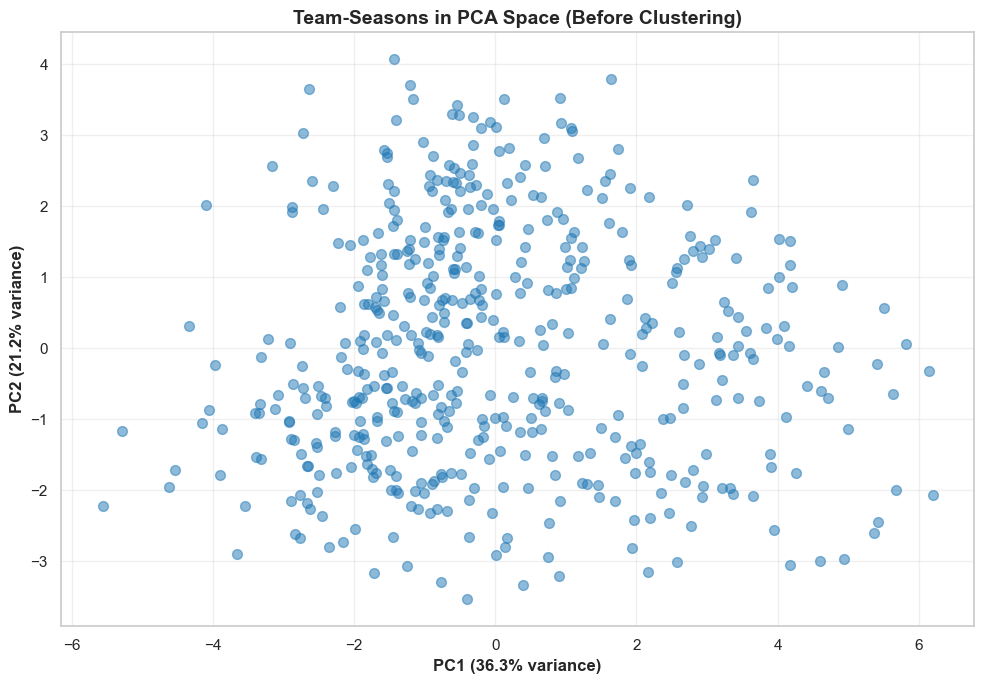

In [52]:
# PCA transformation
pca = PCA(n_components=2, random_state=RANDOM_STATE)
X_pca = pca.fit_transform(X_scaled)

# Create PCA dataframe
df_pca = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
df_pca['Team'] = df_feat['Team'].values
df_pca['Season'] = df_feat['Season'].values

print(f'{"="*80}')
print('PCA DIMENSIONALITY REDUCTION')
print(f'{"="*80}\n')
print(f' Reduced from {len(style_features)} dimensions to 2 principal components')
print(f'\nVariance explained:')
print(f'   • PC1: {pca.explained_variance_ratio_[0]*100:.2f}%')
print(f'   • PC2: {pca.explained_variance_ratio_[1]*100:.2f}%')
print(f'   • Total: {pca.explained_variance_ratio_.sum()*100:.2f}%')

# Visualize PCA projection
plt.figure(figsize=(10, 7))
plt.scatter(X_pca[:, 0], X_pca[:, 1], alpha=0.5, s=50)
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% variance)', fontweight='bold')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% variance)', fontweight='bold')
plt.title('Team-Seasons in PCA Space (Before Clustering)', fontsize=14, fontweight='bold')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

## 8. K-Means Clustering

**Algorithm:** K-Means partitions data into k clusters by minimizing within-cluster sum of squares (WCSS).

**Hyperparameter Selection:** We use two methods to select optimal k:
1. **Elbow Method:** Identify the "elbow" point where adding more clusters yields diminishing returns
2. **Silhouette Score:** Measure how well-separated clusters are (values closer to 1 are better)

K-MEANS CLUSTERING - HYPERPARAMETER OPTIMIZATION

k=2: Inertia=4886.02, Silhouette=0.2330
k=3: Inertia=4001.77, Silhouette=0.2135
k=4: Inertia=3710.48, Silhouette=0.1835
k=5: Inertia=3444.16, Silhouette=0.1688
k=6: Inertia=3233.26, Silhouette=0.1576
k=7: Inertia=3078.21, Silhouette=0.1506
k=8: Inertia=2939.66, Silhouette=0.1461
k=9: Inertia=2832.12, Silhouette=0.1439
k=6: Inertia=3233.26, Silhouette=0.1576
k=7: Inertia=3078.21, Silhouette=0.1506
k=8: Inertia=2939.66, Silhouette=0.1461
k=9: Inertia=2832.12, Silhouette=0.1439


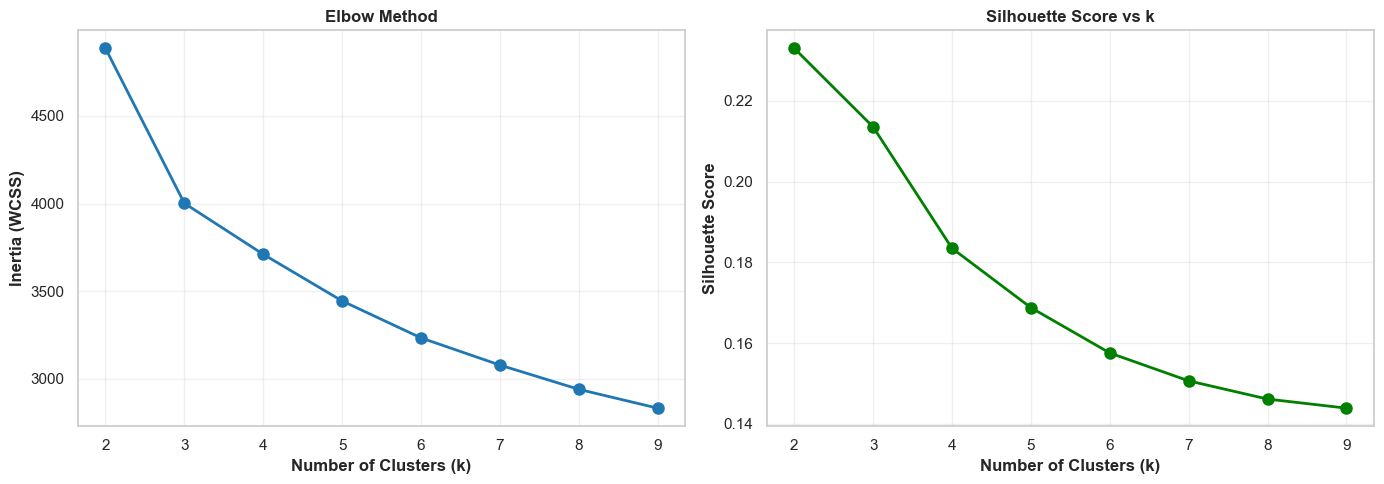


 Best k selected: 2 (Silhouette = 0.2330)


In [53]:
print(f'{"="*80}')
print('K-MEANS CLUSTERING - HYPERPARAMETER OPTIMIZATION')
print(f'{"="*80}\n')

# Test different values of k
K_range = range(2, 10)
inertias = []
silhouettes = []

for k in K_range:
    km = KMeans(n_clusters=k, random_state=RANDOM_STATE, n_init=10)
    labels = km.fit_predict(X_scaled)
    inertias.append(km.inertia_)
    sil = silhouette_score(X_scaled, labels)
    silhouettes.append(sil)
    print(f'k={k}: Inertia={km.inertia_:.2f}, Silhouette={sil:.4f}')

# Plot Elbow method
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.plot(K_range, inertias, marker='o', linewidth=2, markersize=8)
ax1.set_xlabel('Number of Clusters (k)', fontweight='bold')
ax1.set_ylabel('Inertia (WCSS)', fontweight='bold')
ax1.set_title('Elbow Method', fontsize=12, fontweight='bold')
ax1.grid(alpha=0.3)

# Plot Silhouette scores
ax2.plot(K_range, silhouettes, marker='o', linewidth=2, markersize=8, color='green')
ax2.set_xlabel('Number of Clusters (k)', fontweight='bold')
ax2.set_ylabel('Silhouette Score', fontweight='bold')
ax2.set_title('Silhouette Score vs k', fontsize=12, fontweight='bold')
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Select best k based on silhouette score
best_k = K_range[np.argmax(silhouettes)]
print(f'\n Best k selected: {best_k} (Silhouette = {max(silhouettes):.4f})')

### 8.2 Train Final K-Means Model

In [54]:
# Train final K-Means model with best k
kmeans_final = KMeans(n_clusters=best_k, random_state=RANDOM_STATE, n_init=10)
kmeans_labels = kmeans_final.fit_predict(X_scaled)

df_feat['cluster_kmeans'] = kmeans_labels
df_pca['cluster_kmeans'] = kmeans_labels

print(f' K-Means model trained with k={best_k}')
print(f'\nCluster distribution:')
print(pd.Series(kmeans_labels).value_counts().sort_index())

 K-Means model trained with k=2

Cluster distribution:
0    167
1    333
Name: count, dtype: int64


### 8.3 Visualize K-Means Clusters

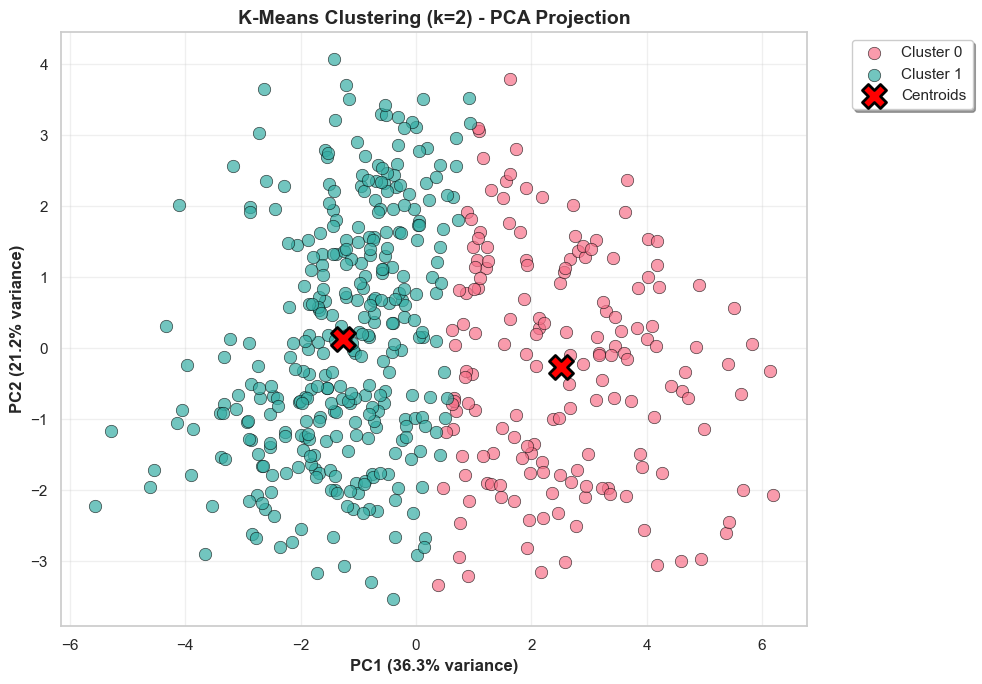

In [55]:
# Visualize clusters in PCA space
plt.figure(figsize=(10, 7))
palette = sns.color_palette('husl', n_colors=best_k)

for cluster in range(best_k):
    mask = kmeans_labels == cluster
    plt.scatter(X_pca[mask, 0], X_pca[mask, 1], 
               color=palette[cluster], label=f'Cluster {cluster}',
               alpha=0.7, s=80, edgecolors='black', linewidth=0.5)

# Plot centroids
centroids_pca = pca.transform(kmeans_final.cluster_centers_)
plt.scatter(centroids_pca[:, 0], centroids_pca[:, 1], 
           c='red', marker='X', s=300, edgecolors='black', linewidth=2,
           label='Centroids', zorder=10)

plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% variance)', fontweight='bold')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% variance)', fontweight='bold')
plt.title(f'K-Means Clustering (k={best_k}) - PCA Projection', fontsize=14, fontweight='bold')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', frameon=True, shadow=True)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

### 8.4 Cluster Profiling & Style Labeling

In [56]:
# Compute cluster profiles (mean standardized values)
profile_df = pd.DataFrame(X_scaled, columns=style_features)
profile_df['Cluster'] = kmeans_labels
cluster_profile_kmeans = profile_df.groupby('Cluster')[style_features].mean()

print(f'{"="*80}')
print('K-MEANS CLUSTER PROFILES (Standardized Feature Means)')
print(f'{"="*80}\n')
print(cluster_profile_kmeans.round(3))

# Define style labels based on cluster characteristics
style_labels_kmeans = {}

for cluster, row in cluster_profile_kmeans.iterrows():
    tags = []
    
    # Aggressive high press: High fouls, cards, shots, corners
    if row['Fouls_per_Match'] > 0.5 and row['Yellow_per_Match'] > 0.4:
        tags.append('Aggressive')
    if row['Avg_Shots'] > 0.5 and row['Avg_Shots_On_Target'] > 0.4:
        tags.append('HighPress')
    
    # Clinical: High offensive efficiency
    if row['Shot_Accuracy'] > 0.6 and row['Avg_Goals_Scored'] > 0.5:
        tags.append('Clinical')
    
    # Defensive: Strong defensive metrics
    if row['Avg_Goals_Conceded'] < -0.4 and row['Clean_Sheet_Rate'] > 0.4:
        tags.append('Defensive')
    
    # Set-piece oriented
    if row['Avg_Corners'] > 0.5:
        tags.append('SetPiece')
    
    # Low efficiency / chaotic
    if row['Goals_per_Shot'] < -0.5:
        tags.append('Inefficient')
    
    # Default: Balanced
    if not tags:
        tags.append('Balanced')
    
    style_labels_kmeans[cluster] = '+'.join(tags)

print(f'\n{"="*80}')
print('PLAYING STYLE LABELS')
print(f'{"="*80}\n')

for cluster, style in style_labels_kmeans.items():
    n_teams = (kmeans_labels == cluster).sum()
    print(f'Cluster {cluster}: {style:30s} ({n_teams} team-seasons)')

# Add style labels to dataframe
df_feat['style_kmeans'] = df_feat['cluster_kmeans'].map(style_labels_kmeans)

K-MEANS CLUSTER PROFILES (Standardized Feature Means)

         Avg_Goals_Scored  Avg_Goals_Conceded  Avg_Shots  Avg_Shots_On_Target  \
Cluster                                                                         
0                   1.024              -0.966      0.969                0.886   
1                  -0.513               0.484     -0.486               -0.444   

         Shot_Accuracy  Clean_Sheet_Rate  Avg_Corners  Fouls_per_Match  \
Cluster                                                                  
0                0.306             0.940        0.935           -0.317   
1               -0.153            -0.471       -0.469            0.159   

         Yellow_per_Match  Red_per_Match  Cards_per_Foul  Goals_per_Shot  \
Cluster                                                                    
0                  -0.456          -0.24          -0.268           0.650   
1                   0.228           0.12           0.134          -0.326   

         Corners_p

## 9. Gaussian Mixture Models (GMM)

**Algorithm:** GMM assumes data is generated from a mixture of Gaussian distributions. Unlike K-Means (hard clustering), GMM provides **soft clustering** with probability assignments.

**Advantages:**
- Captures overlapping clusters (teams with hybrid playing styles)
- Provides uncertainty estimates (probability of belonging to each cluster)
- More flexible cluster shapes (elliptical, not just spherical)

**Hyperparameter Selection:** We use BIC (Bayesian Information Criterion) and AIC (Akaike Information Criterion) to select the number of components. Lower BIC/AIC indicates better model fit with penalty for complexity.

GAUSSIAN MIXTURE MODELS - HYPERPARAMETER OPTIMIZATION

components=2: BIC=7495.47, AIC=6614.62, Silhouette=0.1865
components=3: BIC=6305.46, AIC=4982.07, Silhouette=0.1865
components=4: BIC=5889.16, AIC=4123.24, Silhouette=0.1552
components=5: BIC=6141.39, AIC=3932.93, Silhouette=0.1360
components=6: BIC=5939.25, AIC=3288.26, Silhouette=0.1283
components=7: BIC=6174.30, AIC=3080.78, Silhouette=0.1180
components=8: BIC=6778.20, AIC=3242.15, Silhouette=0.1025
components=5: BIC=6141.39, AIC=3932.93, Silhouette=0.1360
components=6: BIC=5939.25, AIC=3288.26, Silhouette=0.1283
components=7: BIC=6174.30, AIC=3080.78, Silhouette=0.1180
components=8: BIC=6778.20, AIC=3242.15, Silhouette=0.1025
components=9: BIC=7076.63, AIC=3098.04, Silhouette=0.1044
components=9: BIC=7076.63, AIC=3098.04, Silhouette=0.1044


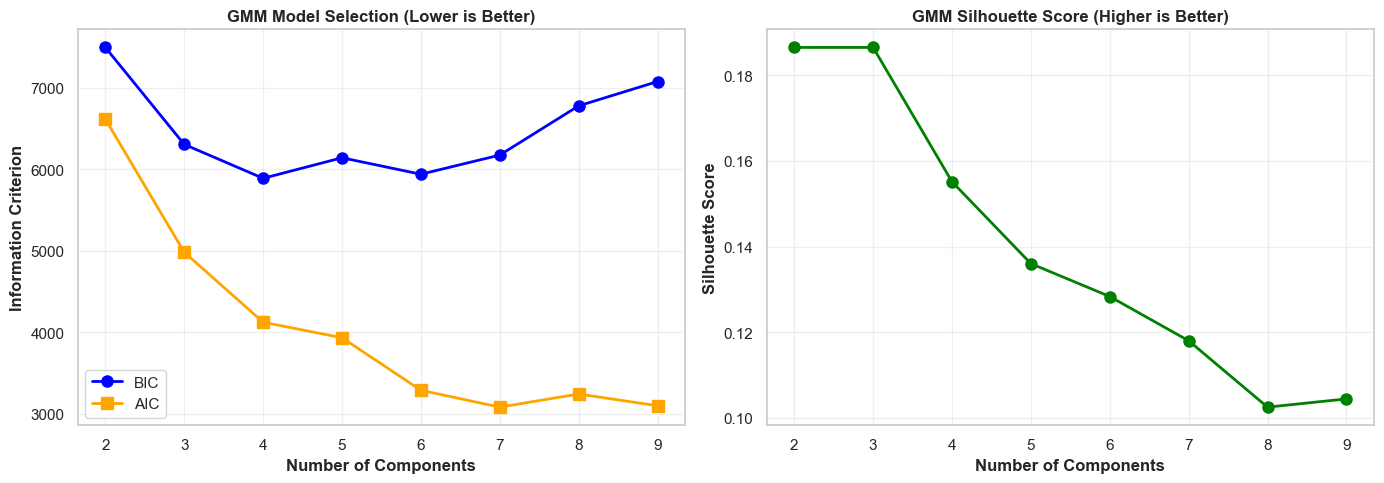


 Best GMM: 3 components
   BIC=6305.46, Silhouette=0.1865


In [57]:
print(f'{"="*80}')
print('GAUSSIAN MIXTURE MODELS - HYPERPARAMETER OPTIMIZATION')
print(f'{"="*80}\n')

# Test different numbers of components
n_components_range = range(2, 10)
results_gmm = []

for n in n_components_range:
    gmm = GaussianMixture(n_components=n, covariance_type='full', random_state=RANDOM_STATE)
    gmm.fit(X_scaled)
    gmm_labels = gmm.predict(X_scaled)
    
    bic = gmm.bic(X_scaled)
    aic = gmm.aic(X_scaled)
    sil = silhouette_score(X_scaled, gmm_labels)
    
    results_gmm.append({
        'components': n,
        'BIC': bic,
        'AIC': aic,
        'silhouette': sil
    })
    print(f'components={n}: BIC={bic:.2f}, AIC={aic:.2f}, Silhouette={sil:.4f}')

gmm_results_df = pd.DataFrame(results_gmm)

# Plot BIC, AIC, and Silhouette
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.plot(gmm_results_df['components'], gmm_results_df['BIC'], 
         marker='o', linewidth=2, markersize=8, label='BIC', color='blue')
ax1.plot(gmm_results_df['components'], gmm_results_df['AIC'], 
         marker='s', linewidth=2, markersize=8, label='AIC', color='orange')
ax1.set_xlabel('Number of Components', fontweight='bold')
ax1.set_ylabel('Information Criterion', fontweight='bold')
ax1.set_title('GMM Model Selection (Lower is Better)', fontsize=12, fontweight='bold')
ax1.legend()
ax1.grid(alpha=0.3)

ax2.plot(gmm_results_df['components'], gmm_results_df['silhouette'], 
         marker='o', linewidth=2, markersize=8, color='green')
ax2.set_xlabel('Number of Components', fontweight='bold')
ax2.set_ylabel('Silhouette Score', fontweight='bold')
ax2.set_title('GMM Silhouette Score (Higher is Better)', fontsize=12, fontweight='bold')
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Select best model: lowest BIC with good silhouette (>90% of max)
max_sil = gmm_results_df['silhouette'].max()
threshold = 0.9 * max_sil
candidates = gmm_results_df[gmm_results_df['silhouette'] >= threshold]
best_model = candidates.loc[candidates['BIC'].idxmin()]
best_components = int(best_model['components'])

print(f'\n Best GMM: {best_components} components')
print(f'   BIC={best_model["BIC"]:.2f}, Silhouette={best_model["silhouette"]:.4f}')

### 9.2 Train Final GMM & Analyze Probabilities

In [58]:
# Train final GMM
gmm_final = GaussianMixture(n_components=best_components, covariance_type='full', random_state=RANDOM_STATE)
gmm_labels = gmm_final.fit_predict(X_scaled)
gmm_probs = gmm_final.predict_proba(X_scaled)

df_feat['cluster_gmm'] = gmm_labels
df_pca['cluster_gmm'] = gmm_labels

print(f' GMM model trained with {best_components} components')
print(f'\nCluster distribution:')
print(pd.Series(gmm_labels).value_counts().sort_index())

# Analyze probability distributions
print(f'\n{"="*80}')
print('SOFT CLUSTERING ANALYSIS (Probability Assignments)')
print(f'{"="*80}\n')

# Find teams with high uncertainty (no dominant cluster)
max_probs = gmm_probs.max(axis=1)
uncertain_mask = max_probs < 0.6  # Less than 60% confidence

print(f'Teams with hybrid styles (max probability < 0.6): {uncertain_mask.sum()}')
print(f'Teams with clear styles (max probability >= 0.6): {(~uncertain_mask).sum()}')

# Show examples of uncertain assignments
if uncertain_mask.sum() > 0:
    uncertain_indices = np.where(uncertain_mask)[0][:5]
    print(f'\nExample hybrid teams:')
    for idx in uncertain_indices:
        team = df_feat.iloc[idx]['Team']
        season = df_feat.iloc[idx]['Season']
        probs = gmm_probs[idx]
        top_clusters = np.argsort(probs)[-2:][::-1]
        print(f'   {team} ({season}): Cluster {top_clusters[0]} ({probs[top_clusters[0]]:.2f}), '
              f'Cluster {top_clusters[1]} ({probs[top_clusters[1]]:.2f})')

 GMM model trained with 3 components

Cluster distribution:
0    140
1    156
2    204
Name: count, dtype: int64

SOFT CLUSTERING ANALYSIS (Probability Assignments)

Teams with hybrid styles (max probability < 0.6): 4
Teams with clear styles (max probability >= 0.6): 496

Example hybrid teams:
   Liverpool (2002-03): Cluster 0 (0.59), Cluster 2 (0.41)
   Chelsea (2007-08): Cluster 2 (0.58), Cluster 0 (0.42)
   Southampton (2013-14): Cluster 0 (0.53), Cluster 1 (0.47)
   Man United (2023-24): Cluster 0 (0.55), Cluster 1 (0.45)


### 9.3 Visualize GMM Clusters & Profile

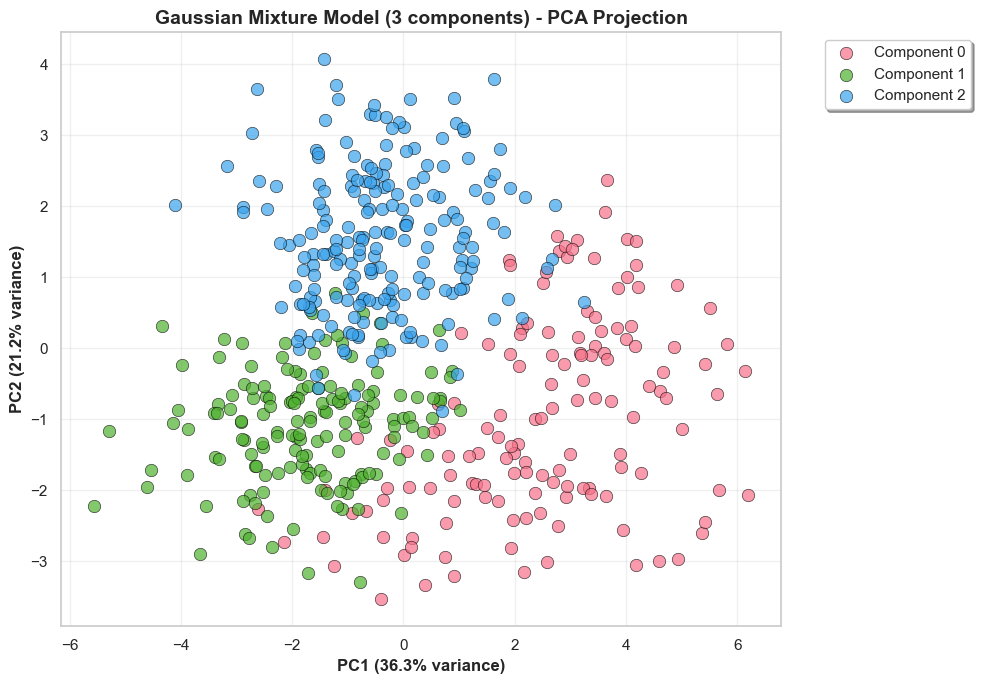


GMM CLUSTER PROFILES (Standardized Feature Means)

         Avg_Goals_Scored  Avg_Goals_Conceded  Avg_Shots  Avg_Shots_On_Target  \
Cluster                                                                         
0                   1.197              -0.897      1.279                0.823   
1                  -0.481               0.540     -0.350               -1.003   
2                  -0.453               0.203     -0.610                0.203   

         Shot_Accuracy  Clean_Sheet_Rate  Avg_Corners  Fouls_per_Match  \
Cluster                                                                  
0               -0.014             0.905        0.967           -0.485   
1               -1.060            -0.473       -0.664           -0.405   
2                0.820            -0.259       -0.156            0.643   

         Yellow_per_Match  Red_per_Match  Cards_per_Foul  Goals_per_Shot  \
Cluster                                                                    
0                  

In [59]:
# Visualize GMM clusters in PCA space
plt.figure(figsize=(10, 7))
palette = sns.color_palette('husl', n_colors=best_components)

for cluster in range(best_components):
    mask = gmm_labels == cluster
    plt.scatter(X_pca[mask, 0], X_pca[mask, 1], 
               color=palette[cluster], label=f'Component {cluster}',
               alpha=0.7, s=80, edgecolors='black', linewidth=0.5)

plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% variance)', fontweight='bold')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% variance)', fontweight='bold')
plt.title(f'Gaussian Mixture Model ({best_components} components) - PCA Projection', 
         fontsize=14, fontweight='bold')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', frameon=True, shadow=True)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Compute cluster profiles
profile_df_gmm = pd.DataFrame(X_scaled, columns=style_features)
profile_df_gmm['Cluster'] = gmm_labels
cluster_profile_gmm = profile_df_gmm.groupby('Cluster')[style_features].mean()

print(f'\n{"="*80}')
print('GMM CLUSTER PROFILES (Standardized Feature Means)')
print(f'{"="*80}\n')
print(cluster_profile_gmm.round(3))

## 10. DBSCAN – Density-Based Clustering

**Algorithm:** DBSCAN (Density-Based Spatial Clustering of Applications with Noise) groups points based on density, identifying:
- **Core points:** Points with ≥ MinPts neighbors within radius ε
- **Border points:** Non-core points within ε of a core point
- **Noise points:** Points that don't belong to any cluster (labeled as -1)

**Advantages:**
- Discovers clusters of arbitrary shape
- Identifies outliers automatically (tactical anomalies)
- No need to specify number of clusters in advance

**Hyperparameters:**
- **ε (epsilon):** Maximum distance between two points to be considered neighbors
- **MinPts:** Minimum number of points to form a dense region

**Rule of thumb:** MinPts ≥ D + 1, where D = number of dimensions (features)

### 10.1 k-Distance Plot for ε Selection

DBSCAN - EPSILON SELECTION USING k-DISTANCE PLOT

MinPts = 14 (based on 13 features + 1)


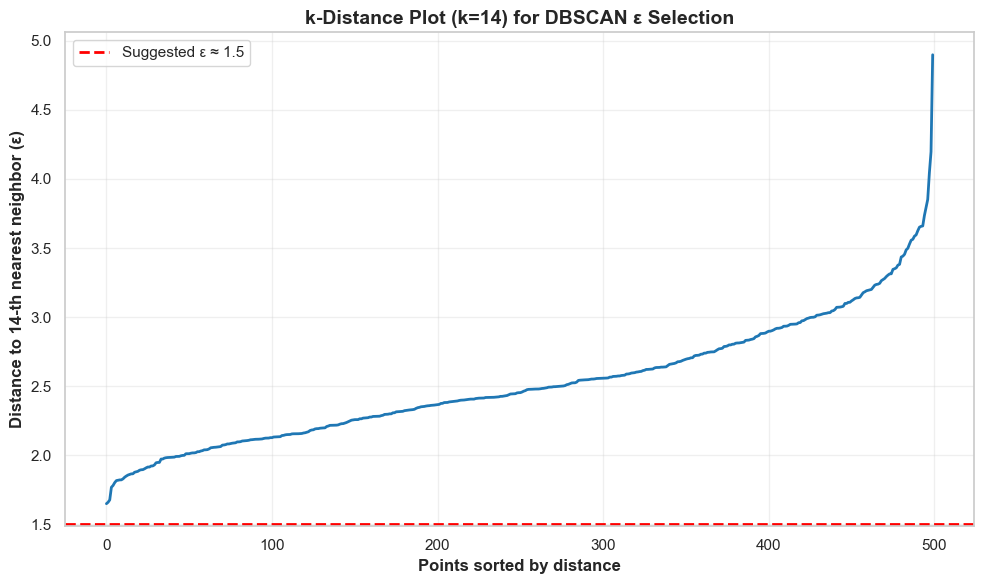


How to select ε:
   • Look for the "elbow" point where the curve has maximum curvature
   • Points to the left of the elbow are in dense regions (core points)
   • Points to the right are in sparse regions (noise/outliers)
   • ε should be set at the elbow point for optimal clustering


In [39]:
print(f'{"="*80}')
print('DBSCAN - EPSILON SELECTION USING k-DISTANCE PLOT')
print(f'{"="*80}\n')

# Set MinPts according to rule: MinPts >= D + 1
min_samples = len(style_features) + 1  # D + 1
print(f'MinPts = {min_samples} (based on {len(style_features)} features + 1)')

# Compute k-nearest neighbors
neigh = NearestNeighbors(n_neighbors=min_samples)
nbrs = neigh.fit(X_scaled)
distances, indices = nbrs.kneighbors(X_scaled)

# Sort distances to k-th nearest neighbor
k_distances = np.sort(distances[:, -1])

# Plot k-distance graph
plt.figure(figsize=(10, 6))
plt.plot(k_distances, linewidth=2)
plt.xlabel('Points sorted by distance', fontweight='bold')
plt.ylabel(f'Distance to {min_samples}-th nearest neighbor (ε)', fontweight='bold')
plt.title(f'k-Distance Plot (k={min_samples}) for DBSCAN ε Selection', 
         fontsize=14, fontweight='bold')
plt.grid(alpha=0.3)
plt.axhline(y=1.5, color='r', linestyle='--', linewidth=2, label='Suggested ε ≈ 1.5')
plt.legend()
plt.tight_layout()
plt.show()

print('\nHow to select ε:')
print('   • Look for the "elbow" point where the curve has maximum curvature')
print('   • Points to the left of the elbow are in dense regions (core points)')
print('   • Points to the right are in sparse regions (noise/outliers)')
print('   • ε should be set at the elbow point for optimal clustering')

### 10.2 Train DBSCAN & Identify Outliers

In [60]:
# Test various epsilon values around the elbow
print(f'\n{"="*80}')
print('TESTING DIFFERENT ε VALUES')
print(f'{"="*80}\n')

best_dbscan = None
best_sil = -1
best_eps = None
best_labels = None

eps_candidates = np.linspace(0.5, 3.0, 11)

for eps in eps_candidates:
    db = DBSCAN(eps=eps, min_samples=min_samples)
    labels = db.fit_predict(X_scaled)
    
    unique = set(labels)
    n_clusters = len(unique) - (1 if -1 in unique else 0)
    n_noise = list(labels).count(-1)
    
    # Skip if all noise or single cluster
    if n_clusters == 0 or len(unique) <= 1:
        print(f'eps={eps:.2f}: All noise or single cluster - skipping')
        continue
    
    # Calculate silhouette (excluding noise points)
    mask = labels != -1
    if mask.sum() < 2:
        continue
    
    try:
        sil = silhouette_score(X_scaled[mask], labels[mask])
        print(f'eps={eps:.2f}: {n_clusters} clusters, {n_noise} noise points, silhouette={sil:.4f}')
        
        if sil > best_sil:
            best_sil = sil
            best_dbscan = db
            best_eps = eps
            best_labels = labels
    except:
        print(f'eps={eps:.2f}: Error calculating silhouette')
        continue

if best_dbscan is not None:
    dbscan_labels = best_labels
    n_clusters_db = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
    n_noise = list(dbscan_labels).count(-1)
    
    df_feat['cluster_dbscan'] = dbscan_labels
    df_pca['cluster_dbscan'] = dbscan_labels
    
    print(f'\n Best DBSCAN configuration:')
    print(f'   ε = {best_eps:.2f}')
    print(f'   MinPts = {min_samples}')
    print(f'   Clusters found: {n_clusters_db}')
    print(f'   Noise points (outliers): {n_noise} ({100*n_noise/len(dbscan_labels):.1f}%)')
    print(f'   Silhouette score: {best_sil:.4f}')
else:
    dbscan_labels = np.array([-1] * len(X_scaled))
    df_feat['cluster_dbscan'] = dbscan_labels
    df_pca['cluster_dbscan'] = dbscan_labels
    print('\n⚠️  DBSCAN found no meaningful clustering')


TESTING DIFFERENT ε VALUES

eps=0.50: All noise or single cluster - skipping
eps=0.75: All noise or single cluster - skipping
eps=1.00: All noise or single cluster - skipping
eps=1.25: All noise or single cluster - skipping
eps=1.50: All noise or single cluster - skipping
eps=1.75: 2 clusters, 455 noise points, silhouette=0.3961
eps=2.00: 2 clusters, 282 noise points, silhouette=0.3036
eps=2.25: Error calculating silhouette
eps=2.50: Error calculating silhouette
eps=2.75: Error calculating silhouette
eps=3.00: Error calculating silhouette

 Best DBSCAN configuration:
   ε = 1.75
   MinPts = 14
   Clusters found: 2
   Noise points (outliers): 455 (91.0%)
   Silhouette score: 0.3961


### 10.3 Visualize DBSCAN & Analyze Outliers

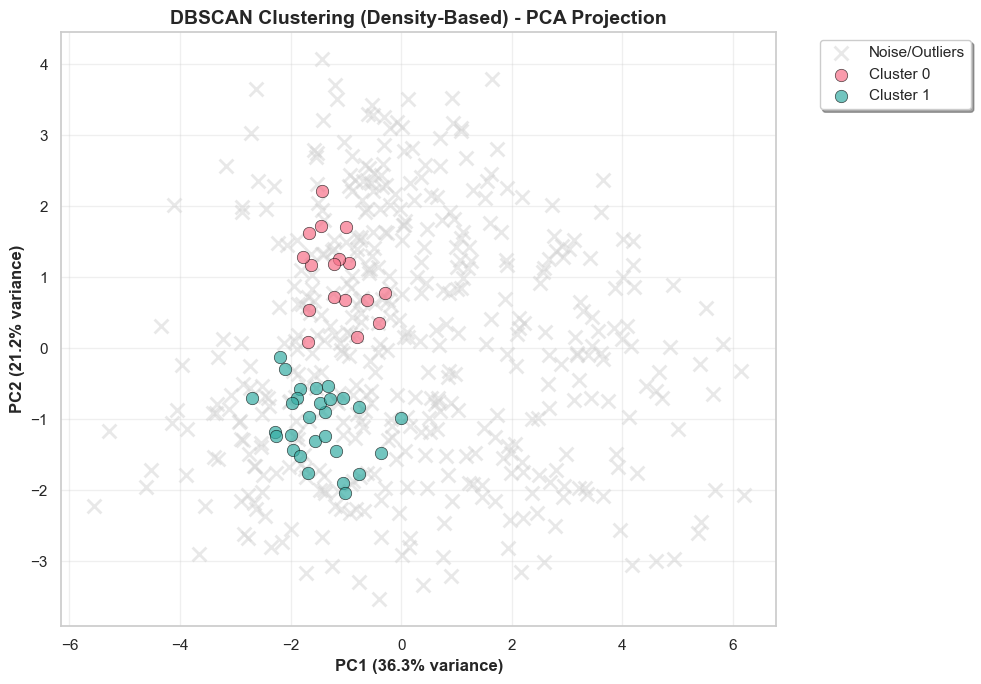


TACTICAL OUTLIERS (DBSCAN Noise Points)

Found 455 outlier team-seasons with atypical playing styles:

 Season        Team  Win_Rate  Avg_Goals_Scored  Avg_Goals_Conceded  Fouls_per_Match  Yellow_per_Match
2000-01  Man United  0.631579          2.078947            0.815789        11.394737          1.157895
2000-01     Arsenal  0.526316          1.657895            1.000000        13.026316          1.263158
2000-01   Liverpool  0.526316          1.868421            1.026316        12.447368          1.315789
2000-01       Leeds  0.526316          1.684211            1.131579        15.500000          1.894737
2000-01     Ipswich  0.526316          1.500000            1.105263        10.894737          0.815789
2000-01     Chelsea  0.447368          1.789474            1.184211        14.342105          1.973684
2000-01  Sunderland  0.394737          1.210526            1.078947        16.263158          1.921053
2000-01 Aston Villa  0.342105          1.210526            1.131579     

In [61]:
# Visualize DBSCAN clusters
plt.figure(figsize=(10, 7))
unique_labels = sorted(set(dbscan_labels))
n_clusters_viz = len(unique_labels) - (1 if -1 in unique_labels else 0)
palette = sns.color_palette('husl', n_colors=max(n_clusters_viz, 1))

for idx, lab in enumerate(unique_labels):
    mask = dbscan_labels == lab
    if lab == -1:
        # Noise points
        plt.scatter(X_pca[mask, 0], X_pca[mask, 1], 
                   c='lightgray', label='Noise/Outliers', alpha=0.5, 
                   marker='x', s=100, linewidths=2)
    else:
        plt.scatter(X_pca[mask, 0], X_pca[mask, 1], 
                   color=palette[lab % len(palette)], label=f'Cluster {lab}',
                   alpha=0.7, s=80, edgecolors='black', linewidth=0.5)

plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% variance)', fontweight='bold')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% variance)', fontweight='bold')
plt.title('DBSCAN Clustering (Density-Based) - PCA Projection', 
         fontsize=14, fontweight='bold')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', frameon=True, shadow=True)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Analyze outlier teams
if -1 in dbscan_labels:
    outlier_indices = np.where(dbscan_labels == -1)[0]
    print(f'\n{"="*80}')
    print(f'TACTICAL OUTLIERS (DBSCAN Noise Points)')
    print(f'{"="*80}\n')
    print(f'Found {len(outlier_indices)} outlier team-seasons with atypical playing styles:\n')
    
    outlier_df = df_feat.iloc[outlier_indices][['Season', 'Team', 'Win_Rate', 
                                                  'Avg_Goals_Scored', 'Avg_Goals_Conceded',
                                                  'Fouls_per_Match', 'Yellow_per_Match']]
    print(outlier_df.head(10).to_string(index=False))
    print('\nThese teams exhibit unusual tactical patterns not fitting standard playing styles.')
else:
    print('\n✅ No outliers detected by DBSCAN')

## 11. Algorithm Comparison

Compare the three clustering methods using multiple evaluation metrics:

CLUSTERING ALGORITHM COMPARISON

Evaluation Metrics:
   • Silhouette Score: Measures cluster separation (higher is better, range: -1 to 1)
   • Calinski-Harabasz: Ratio of between-cluster to within-cluster variance (higher is better)
   • Davies-Bouldin: Average similarity between clusters (lower is better)

 Method  Clusters  Silhouette  Calinski-Harabasz  Davies-Bouldin
 DBSCAN         2    0.396074          37.888837        1.006931
K-Means         2    0.233030         164.501831        1.600373
    GMM         3    0.186526         131.404059        1.660742


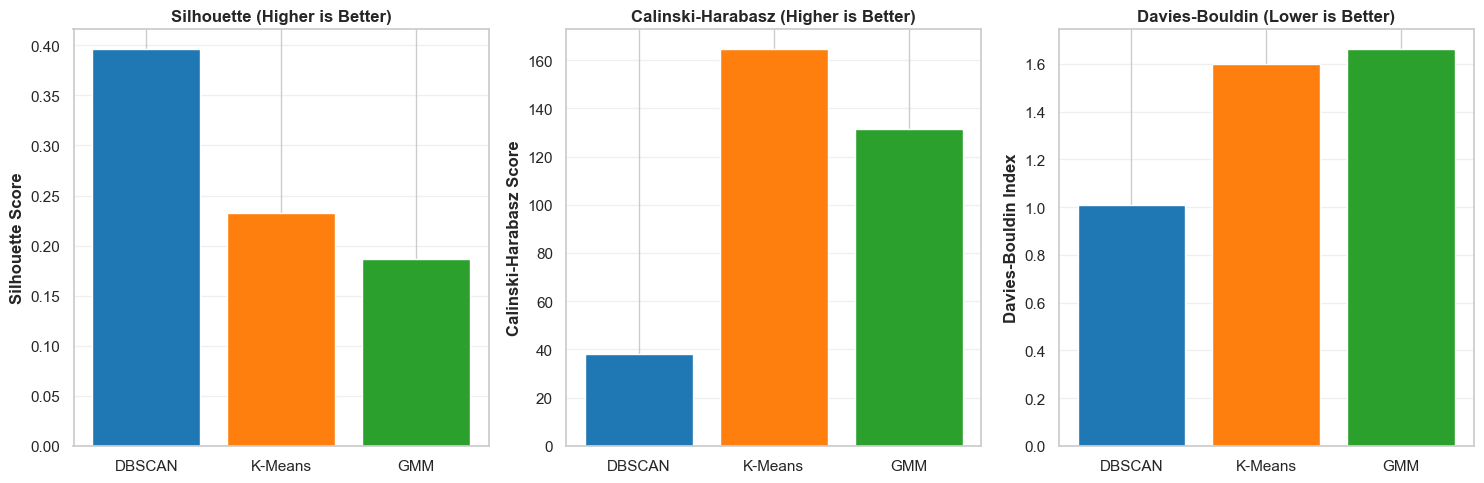


🏆 Best Method by Silhouette Score: DBSCAN


In [42]:
print(f'{"="*80}')
print('CLUSTERING ALGORITHM COMPARISON')
print(f'{"="*80}\n')

def compute_scores(X, labels, method_name):
    """Compute clustering quality metrics"""
    unique_labels = set(labels)
    n_clusters = len(unique_labels) - (1 if -1 in unique_labels else 0)
    
    if n_clusters <= 1:
        return {
            'Method': method_name,
            'Clusters': n_clusters,
            'Silhouette': np.nan,
            'Calinski-Harabasz': np.nan,
            'Davies-Bouldin': np.nan
        }
    
    # Exclude noise points for DBSCAN
    if -1 in labels:
        mask = labels != -1
        if mask.sum() < 2:
            return {
                'Method': method_name,
                'Clusters': n_clusters,
                'Silhouette': np.nan,
                'Calinski-Harabasz': np.nan,
                'Davies-Bouldin': np.nan
            }
        X_eval = X[mask]
        labels_eval = labels[mask]
    else:
        X_eval = X
        labels_eval = labels
    
    return {
        'Method': method_name,
        'Clusters': n_clusters,
        'Silhouette': silhouette_score(X_eval, labels_eval),
        'Calinski-Harabasz': calinski_harabasz_score(X_eval, labels_eval),
        'Davies-Bouldin': davies_bouldin_score(X_eval, labels_eval)
    }

# Compute scores for each method
scores_kmeans = compute_scores(X_scaled, kmeans_labels, 'K-Means')
scores_gmm = compute_scores(X_scaled, gmm_labels, 'GMM')
scores_dbscan = compute_scores(X_scaled, dbscan_labels, 'DBSCAN')

# Create comparison dataframe
comparison_df = pd.DataFrame([scores_kmeans, scores_gmm, scores_dbscan])
comparison_df = comparison_df.sort_values('Silhouette', ascending=False)

print('Evaluation Metrics:')
print('   • Silhouette Score: Measures cluster separation (higher is better, range: -1 to 1)')
print('   • Calinski-Harabasz: Ratio of between-cluster to within-cluster variance (higher is better)')
print('   • Davies-Bouldin: Average similarity between clusters (lower is better)\n')

print(comparison_df.to_string(index=False))

# Visualize comparison
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Silhouette
axes[0].bar(comparison_df['Method'], comparison_df['Silhouette'], color=['#1f77b4', '#ff7f0e', '#2ca02c'])
axes[0].set_ylabel('Silhouette Score', fontweight='bold')
axes[0].set_title('Silhouette (Higher is Better)', fontweight='bold')
axes[0].grid(axis='y', alpha=0.3)

# Calinski-Harabasz
axes[1].bar(comparison_df['Method'], comparison_df['Calinski-Harabasz'], color=['#1f77b4', '#ff7f0e', '#2ca02c'])
axes[1].set_ylabel('Calinski-Harabasz Score', fontweight='bold')
axes[1].set_title('Calinski-Harabasz (Higher is Better)', fontweight='bold')
axes[1].grid(axis='y', alpha=0.3)

# Davies-Bouldin
axes[2].bar(comparison_df['Method'], comparison_df['Davies-Bouldin'], color=['#1f77b4', '#ff7f0e', '#2ca02c'])
axes[2].set_ylabel('Davies-Bouldin Index', fontweight='bold')
axes[2].set_title('Davies-Bouldin (Lower is Better)', fontweight='bold')
axes[2].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print(f'\n🏆 Best Method by Silhouette Score: {comparison_df.iloc[0]["Method"]}')

### Key Insights

**K-Means:**
- Simple, stable, and easily interpretable
- Assumes spherical clusters of similar size
- Best for clear, well-separated playing styles

**GMM:**
- Captures soft cluster boundaries (hybrid styles)
- Handles elliptical cluster shapes
- Provides probability assignments for uncertainty quantification

**DBSCAN:**
- Identifies outliers automatically (atypical tactical approaches)
- Discovers clusters of arbitrary shape
- Sensitive to ε and MinPts parameters

## 12. Tactical Evolution & Outliers Analysis

Now we connect clustering results back to the business objective: tracking how teams' playing styles evolve over time and identifying sudden tactical changes.

In [62]:
# Prepare style evolution data (using K-Means as primary method)
style_evolution = df_feat[['Season', 'Team', 'cluster_kmeans', 'style_kmeans']].copy()
style_evolution = style_evolution.sort_values(['Team', 'Season'])

print(f'{"="*80}')
print('TACTICAL STYLE EVOLUTION ANALYSIS')
print(f'{"="*80}\n')

# Count style changes per team
def count_style_changes(group):
    """Count number of times a team changed playing style"""
    return (group['cluster_kmeans'] != group['cluster_kmeans'].shift()).sum() - 1

style_changes = style_evolution.groupby('Team').apply(count_style_changes).sort_values(ascending=False)
style_changes = style_changes[style_changes > 0]  # Only teams with changes

print(f'Teams with Most Tactical Changes (Top 10):')
print(f'{"Team":<25} {"Style Changes":>15}')
print('-' * 42)
for team, changes in style_changes.head(10).items():
    print(f'{team:<25} {changes:>15}')

# Identify teams with unstable tactics
unstable_teams = style_changes[style_changes >= 3].index.tolist()
print(f'\n  Teams with unstable tactics (≥3 style changes): {len(unstable_teams)}')

# Identify teams that remained consistent
all_teams = style_evolution['Team'].unique()
consistent_teams = [t for t in all_teams if t not in style_changes.index]
print(f' Teams with consistent tactics (no changes): {len(consistent_teams)}')

TACTICAL STYLE EVOLUTION ANALYSIS

Teams with Most Tactical Changes (Top 10):
Team                        Style Changes
------------------------------------------
Tottenham                               8
Aston Villa                             6
Newcastle                               5
Man United                              5
Leicester                               4
Everton                                 4
Southampton                             4
Chelsea                                 4
Fulham                                  4
Man City                                3

  Teams with unstable tactics (≥3 style changes): 11
 Teams with consistent tactics (no changes): 23


### 12.2 Visualize Tactical Evolution for Sample Teams

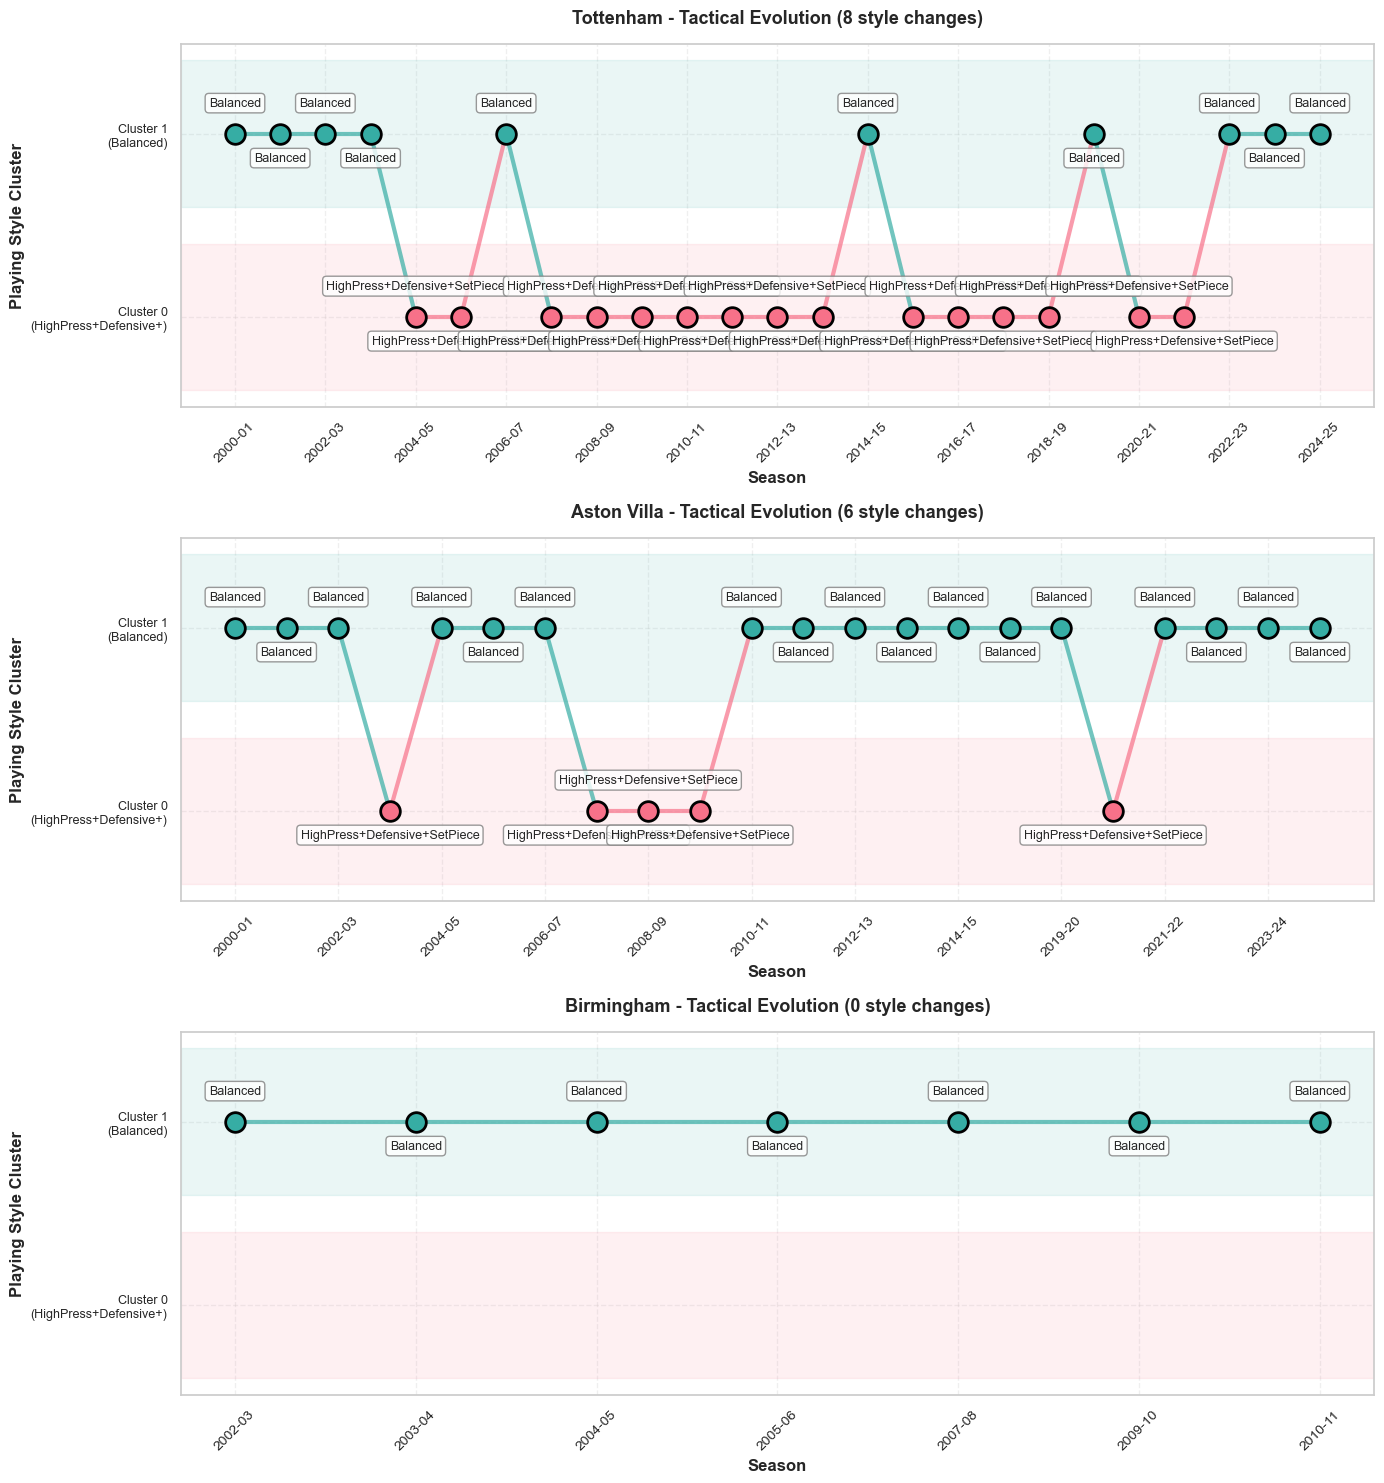


INTERPRETATION GUIDE
   • Horizontal lines = Consistent tactical approach over multiple seasons
   • Vertical jumps = Sudden tactical shifts (likely manager/coaching changes)
   • Gradual changes = Tactical evolution or squad rebuild
   • Color coding = Each cluster has a distinct color for easy tracking

Example insights:
   • Tottenham: VOLATILE - 8 style changes (high tactical instability)
   • Aston Villa: VOLATILE - 6 style changes (high tactical instability)
   • Birmingham: STABLE - No style changes detected


In [65]:
# Select teams for visualization: most changes + most consistent
sample_teams = []
if len(style_changes) > 0:
    sample_teams.extend(style_changes.head(2).index.tolist())  # 2 most unstable
if len(consistent_teams) > 0:
    sample_teams.extend(consistent_teams[:1])  # 1 most consistent

# If we don't have 3 teams, pick any available teams
if len(sample_teams) < 3:
    all_available = style_evolution['Team'].unique()
    sample_teams = all_available[:min(3, len(all_available))].tolist()

if len(sample_teams) > 0:
    fig, axes = plt.subplots(len(sample_teams), 1, figsize=(14, 5*len(sample_teams)))
    if len(sample_teams) == 1:
        axes = [axes]
    
    # Color palette for clusters
    cluster_colors = sns.color_palette('husl', n_colors=best_k)
    
    for idx, team in enumerate(sample_teams):
        team_data = style_evolution[style_evolution['Team'] == team].sort_values('Season')
        
        # Count style changes for this team
        n_changes = (team_data['cluster_kmeans'] != team_data['cluster_kmeans'].shift()).sum() - 1
        
        # Plot line with cluster-specific colors
        for i in range(len(team_data) - 1):
            row_curr = team_data.iloc[i]
            row_next = team_data.iloc[i + 1]
            
            cluster_curr = row_curr['cluster_kmeans']
            axes[idx].plot([row_curr['Season'], row_next['Season']], 
                          [cluster_curr, row_next['cluster_kmeans']],
                          color=cluster_colors[cluster_curr], linewidth=3, alpha=0.7)
        
        # Plot markers with cluster colors
        for season_idx, (_, row) in enumerate(team_data.iterrows()):
            cluster = row['cluster_kmeans']
            axes[idx].scatter(row['Season'], cluster, 
                            color=cluster_colors[cluster], 
                            s=200, edgecolors='black', linewidth=2, zorder=5)
            
            # Add style label as text annotation (alternating above/below to avoid overlap)
            if pd.notna(row['style_kmeans']):
                y_offset = 0.15 if season_idx % 2 == 0 else -0.15
                axes[idx].text(row['Season'], cluster + y_offset, 
                              row['style_kmeans'], 
                              fontsize=9, ha='center', 
                              bbox=dict(boxstyle='round,pad=0.3', facecolor='white', 
                                       edgecolor='gray', alpha=0.8))
        
        axes[idx].set_xlabel('Season', fontsize=12, fontweight='bold')
        axes[idx].set_ylabel('Playing Style Cluster', fontsize=12, fontweight='bold')
        axes[idx].set_title(f'{team} - Tactical Evolution ({n_changes} style change{"s" if n_changes != 1 else ""})', 
                          fontsize=13, fontweight='bold', pad=15)
        axes[idx].grid(alpha=0.3, linestyle='--')
        axes[idx].set_yticks(range(best_k))
        
        # Set y-axis labels to show cluster + style
        y_labels = [f'Cluster {i}\n({style_labels_kmeans[i][:20]})' for i in range(best_k)]
        axes[idx].set_yticklabels(y_labels, fontsize=9)
        
        # Rotate x-axis labels for better readability and show fewer labels if too many seasons
        seasons_list = team_data['Season'].tolist()
        if len(seasons_list) > 10:
            # Show every 2nd season if too many
            step = 2
            tick_positions = range(0, len(seasons_list), step)
            axes[idx].set_xticks([seasons_list[i] for i in tick_positions])
        axes[idx].tick_params(axis='x', rotation=45, labelsize=10)
        
        # Add horizontal span for each cluster
        for cluster_id in range(best_k):
            axes[idx].axhspan(cluster_id - 0.4, cluster_id + 0.4, 
                            alpha=0.1, color=cluster_colors[cluster_id])
    
    plt.tight_layout()
    plt.show()
    
    print('\n' + '='*80)
    print('INTERPRETATION GUIDE')
    print('='*80)
    print('   • Horizontal lines = Consistent tactical approach over multiple seasons')
    print('   • Vertical jumps = Sudden tactical shifts (likely manager/coaching changes)')
    print('   • Gradual changes = Tactical evolution or squad rebuild')
    print('   • Color coding = Each cluster has a distinct color for easy tracking')
    print('\nExample insights:')
    for team in sample_teams:
        team_data = style_evolution[style_evolution['Team'] == team].sort_values('Season')
        n_changes = (team_data['cluster_kmeans'] != team_data['cluster_kmeans'].shift()).sum() - 1
        if n_changes == 0:
            print(f'   • {team}: STABLE - No style changes detected')
        elif n_changes <= 2:
            print(f'   • {team}: MODERATE - {n_changes} tactical shift(s)')
        else:
            print(f'   • {team}: VOLATILE - {n_changes} style changes (high tactical instability)')
else:
    print('Insufficient data to visualize tactical evolution')

## 13. Export Results

Save clustering assignments for integration with other business objectives (BO1 season rankings, BO2 match predictions).

In [66]:
# Prepare output dataframe
output_df = df_feat[['Season', 'Team']].copy()
output_df['Cluster_KMeans'] = df_feat['cluster_kmeans']
output_df['Style_KMeans'] = df_feat['style_kmeans']
output_df['Cluster_GMM'] = df_feat['cluster_gmm']
output_df['Cluster_DBSCAN'] = df_feat['cluster_dbscan']

# Export to CSV
export_path = team_file.parent / 'team_style_clusters.csv'
output_df.to_csv(export_path, index=False)

print(f'{"="*80}')
print('EXPORT SUMMARY')
print(f'{"="*80}\n')
print(f' Cluster assignments exported to:')
print(f'   {export_path}\n')
print(f'Exported columns: {list(output_df.columns)}')
print(f'Total rows: {len(output_df)}')
print(f'\nSample output:')
print(output_df.head(10).to_string(index=False))

EXPORT SUMMARY

 Cluster assignments exported to:
   C:\Users\ezera\OneDrive\Desktop\4Arctic\S1\Machine Learning Appliqué\pl-standings-prediction-project\data\processed\team_style_clusters.csv

Exported columns: ['Season', 'Team', 'Cluster_KMeans', 'Style_KMeans', 'Cluster_GMM', 'Cluster_DBSCAN']
Total rows: 500

Sample output:
 Season        Team  Cluster_KMeans                 Style_KMeans  Cluster_GMM  Cluster_DBSCAN
2000-01  Man United               0 HighPress+Defensive+SetPiece            0              -1
2000-01     Arsenal               0 HighPress+Defensive+SetPiece            0              -1
2000-01   Liverpool               0 HighPress+Defensive+SetPiece            0              -1
2000-01       Leeds               0 HighPress+Defensive+SetPiece            2              -1
2000-01     Ipswich               0 HighPress+Defensive+SetPiece            0              -1
2000-01     Chelsea               0 HighPress+Defensive+SetPiece            0              -1
2000-01  Sun

## 14. Final Conclusion

- Tactical identities are measurable and stable for some clubs; others show frequent style shifts linked to coaching changes or squad rebuilds.
- Tactical stability provides a practical metric for club consistency over time.
- The clustering framework (K-Means, GMM, DBSCAN) offers complementary insights: clear style labels, hybrid tendencies, and outliers.

### Business Impact
- Scouting: Match player profiles to clubs with compatible styles; prioritize transfers from tactically aligned teams.
- Coaching: Benchmark style vs. league, monitor evolution season-to-season, and focus on styles correlated with stronger standings.

This BO delivers an actionable playstyle map of the league, enabling better recruitment fit, tactical benchmarking, and tracking of evolution with minimal complexity.